In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os,sys, kimimaro
import numpy as np
from skimage.morphology import disk, ball, square
import scipy.ndimage as nd
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import cloudvolume as cv
from IPython.display import HTML
from matplotlib.collections import LineCollection

sys.path.append("/home/phornauer/Git/axon_tracking/")
import axon_tracking.skeletonization as skel
import axon_tracking.template_extraction as te
import axon_tracking.visualization as vis
import axon_tracking.utils as ut

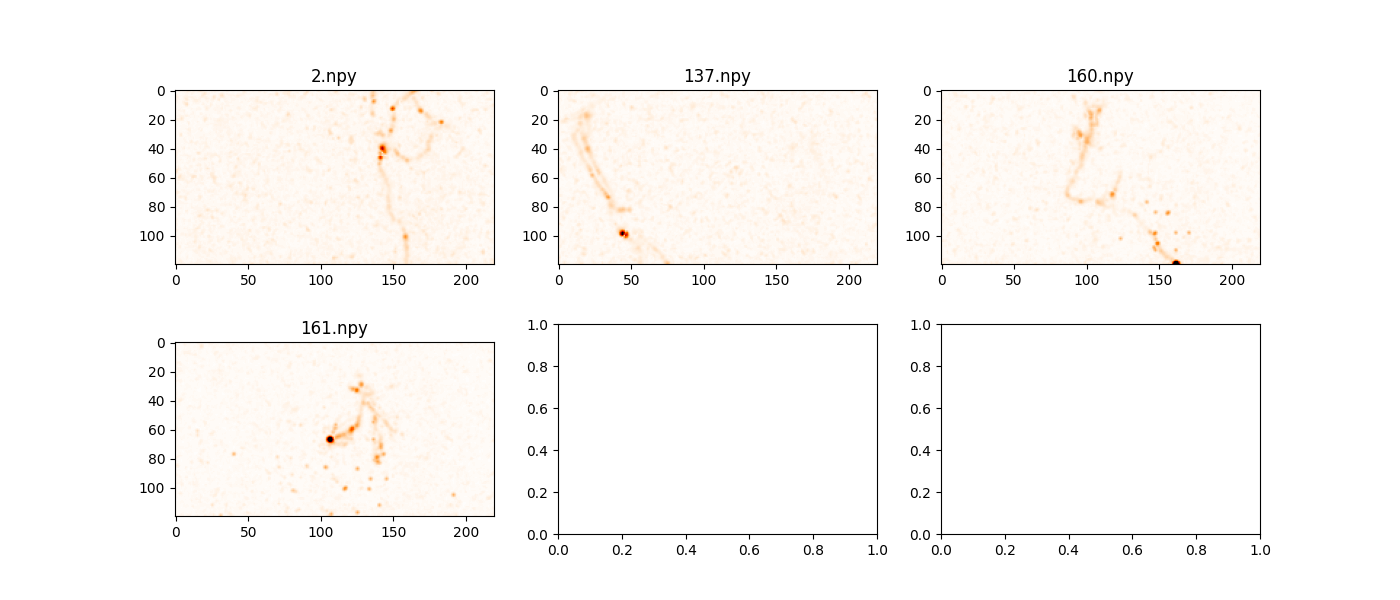

In [7]:
root_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/EI_iNeurons/241218/T002523/AxonTracking'
stream_id = 'well003'
suffix = "sorter_output" 
overview_path = os.path.join(root_path, stream_id, suffix) 
vis.plot_template_overview(overview_path, n_cols = 3, vmin=-10, vmax=0, filename='overview', unit_ids= None, overwrite=False)

In [5]:
params = dict()
params['noise_threshold'] = -0.5 # Noise threshold as factor of the noise level (None to skip)
params['abs_threshold'] = -0.15 # Absolut threshold in [uV]/sample
params['upsample'] = [0.5,0.5,0.25] # Spacing for interpolation in [x,y,z] direction
params['sampling_rate'] = 10000/params['upsample'][2] # [Hz]
params['ms_cutout'] = [3.0, 5.0] # Cutout in ms before and after the spike
#params['filter_footprint'] = ball(1)
params['max_velocity'] = 0.8 # [m/s]
params['max_noise_level'] = 0.25 # Mean of the noise level/matrix
params['el_spacing'] = 17.5 * params['upsample'][0] # Electrode spacing in um
params['ais_detection'] = "dev" # "time" or "dev" or "amp" or None
params['buffer_frames'] = 10 # Buffer frames for the ais cutout

In [9]:
root_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/EI_iNeurons/241218/T002523/AxonTracking'
stream_id = 'well003'
suffix = "sorter_output" # Typically the sorter_output folder
template_folder = "templates" # Subfolder containing the templates
template_id = 137
full_path = os.path.join(root_path, stream_id, suffix, template_folder) 
template, template_save_file = skel.load_template_file(full_path, template_id)

In [10]:
interp_temp, interp_noise, ais = skel.preprocess_template(template, params)

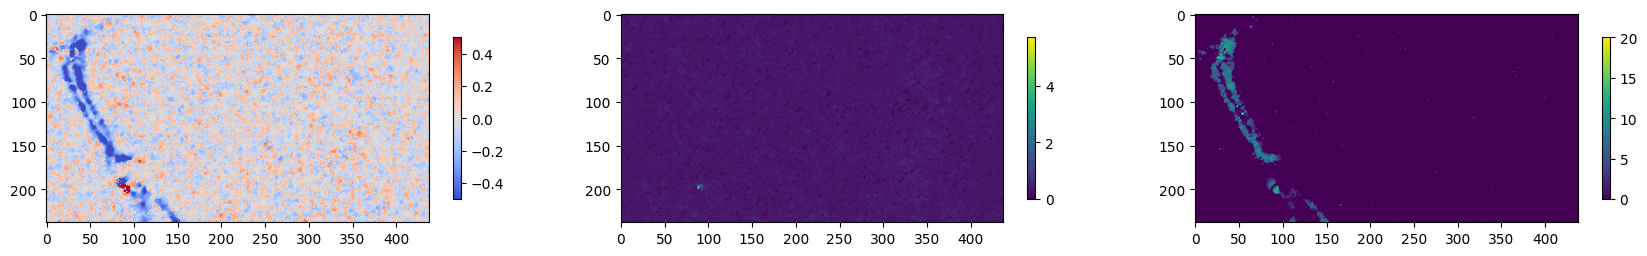

In [11]:
params['max_velocity'] = 0.8 # [m/s]
params['abs_threshold'] = -0.1
params['noise_threshold'] = -0.75
th_template = skel.threshold_template(interp_temp, interp_noise, ais, params)
vis.plot_template_and_noise(interp_temp, interp_noise, th_template, vrange=[-0.5, 0.5])

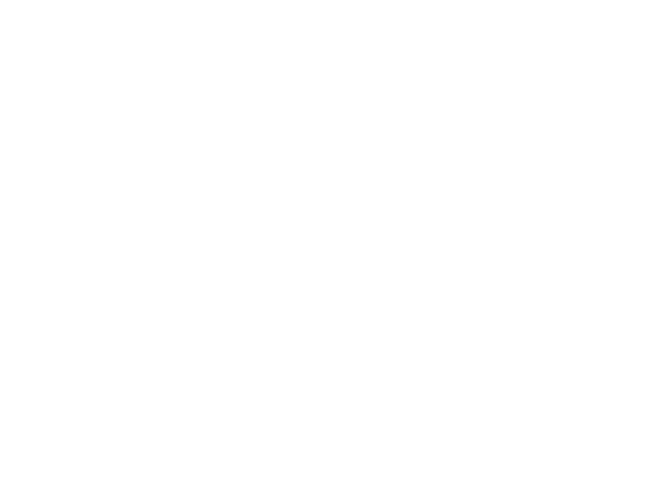

In [12]:
ani = vis.generate_propagation_gif(interp_temp, params = params, cumulative=False, downsample=4, clim=[-1,-0.01], cmap="Greys", marker_size=0.1,spacing=1)
HTML(ani.to_jshtml())

In [ ]:
skel_params = dict()
skel_params['scale'] = 2#1
skel_params['const'] = 10#3
skel_params['dust_threshold'] = 10
skel_params['anisotropy'] = (10,10,10)
skel_params['tick_threshold'] = 10
skel_params['n_jobs'] = 16

In [ ]:
t_cap = [0, th_template.shape[2]] #in samples
skels = skel.skeletonize(th_template[:,:,t_cap[0]:t_cap[1]].astype('bool'), **skel_params)

skeleton = kimimaro.join_close_components(skels[1], radius=50)
skeleton = kimimaro.postprocess(skeleton, tick_threshold=5, dust_threshold=10)
skeleton = skeleton.consolidate()

Skeletonizing Labels:  59%|█████▉    | 16/27 [00:00<00:00, 63.89it/s]


In [21]:
skeleton = skeleton.average_smoothing(n=4,check_boundary=False) #Interferes with scaling
skel_paths = cv.Skeleton.paths(skeleton)
skel_paths_scaled = ut.convert_coor_scale(skel_paths, params)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

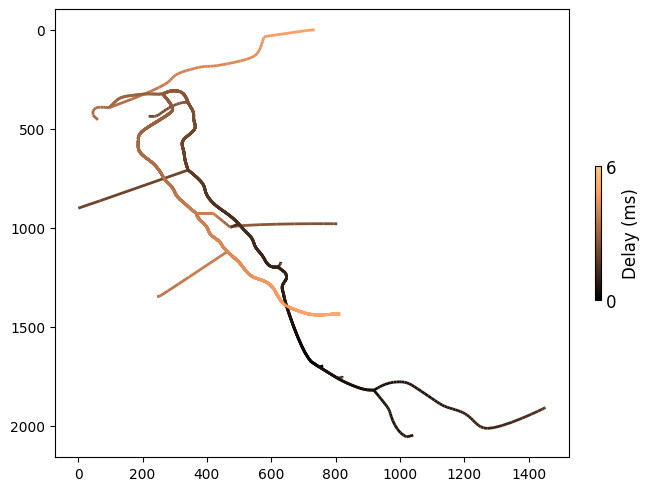

In [26]:
vis.plot_delay_skeleton(skel_paths_scaled, params, skel_params, figsize=0.5, ais=None, plot_ais_connection=False)

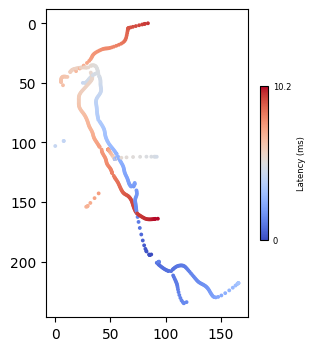

In [23]:
x,y,z = vis.plot_skeleton(skeleton, marker_size=3,fig_size=4,ais=[])

In [27]:
qc_params = dict()
qc_params['window_size'] = 5
qc_params['max_duplicate_ratio'] = 0.3
qc_params['min_r2'] = 0.9
qc_params['vel_range'] = [0.3, 0.8]
qc_params['min_length'] = 1

In [28]:
all_branches = skel.branches_from_paths(skeleton)
scaled_qc_list, r2s, vels, lengths = skel.perform_path_qc(all_branches, params,**qc_params)

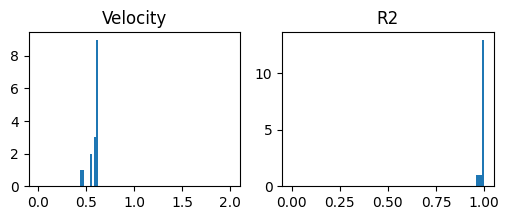

In [29]:
vis.plot_velocity_qc(vels,r2s,fig_size=(6,2))

(<Figure size 640x480 with 2 Axes>, <Axes: >)

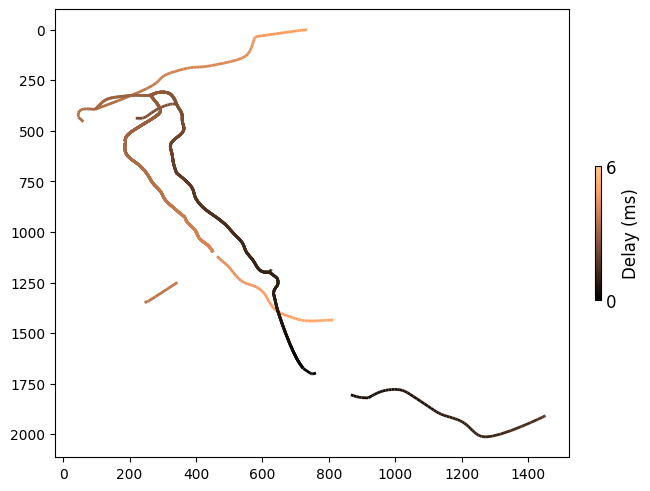

In [30]:
vis.plot_delay_skeleton(scaled_qc_list, params, skel_params, figsize=0.5, ais=None, plot_ais_connection=False)

In [32]:
qc_skel = [skeleton.from_path(x) for x in scaled_qc_list]

In [45]:
qc_skeleton = skeleton.simple_merge(qc_skel)
qc_skeleton = kimimaro.join_close_components(qc_skeleton,radius=100)
qc_skeleton = kimimaro.postprocess(qc_skeleton, dust_threshold=500, tick_threshold=10)
qc_skeleton = qc_skeleton.consolidate()

761.25


(<Figure size 640x480 with 2 Axes>, <Axes: >)

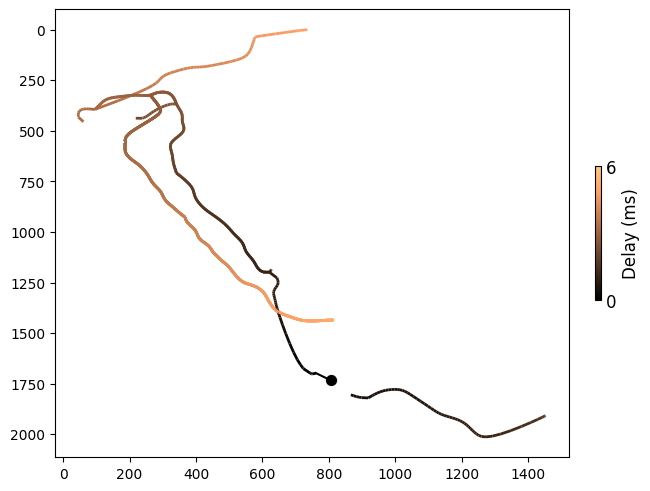

In [54]:
ais_um = np.array(ais) * (params["el_spacing"],params["el_spacing"],1)
vis.plot_delay_skeleton(qc_skeleton.paths(), params, skel_params,figsize=0.5, ais=ais_um, plot_ais_connection=True)

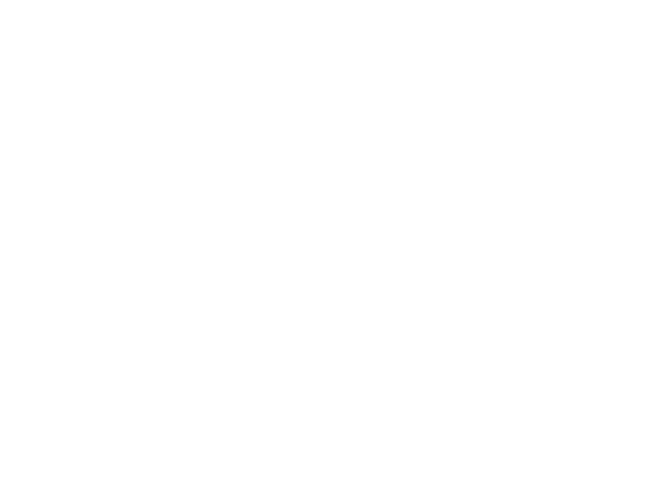

In [ ]:
plot_vertices = qc_skeleton.vertices / (params["el_spacing"],params["el_spacing"],1) # convert x and y to um, keep z in samples
ani = vis.generate_propagation_gif(interp_temp, params = params, cumulative=False, vertices=plot_vertices, downsample=4, clim=[-2, -0.1], cmap="Greys", marker_size=0.1)
HTML(ani.to_jshtml())

In [76]:
np.min(interp_temp)

-2.816161632537842

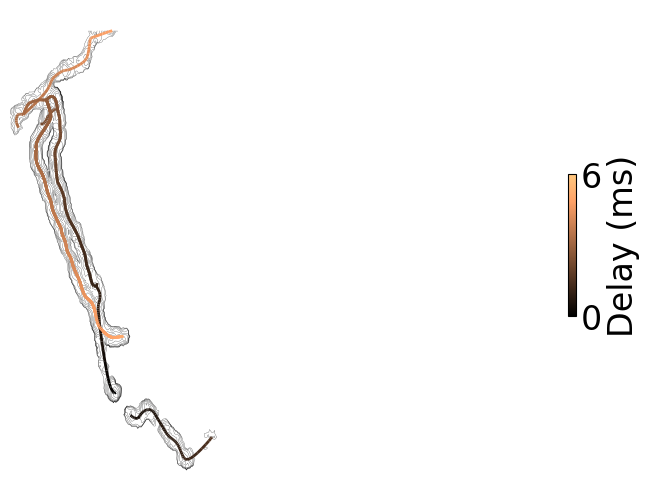

In [79]:
save_path = os.path.join(root_path,stream_id,str(template_id)+'_delay.png')
vis.plot_delay_contour(interp_temp,qc_skeleton,params,skel_params, radius=5, save_path=[], linewidth=2, n_contours = 10)

In [71]:
save_path = os.path.join(root_path,stream_id,str(template_id)+'.png')
save_path

'/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/EI_iNeurons/241218/T002523/AxonTracking/well003/137.png'

In [86]:
np.min(interp_temp)

-2.816161632537842

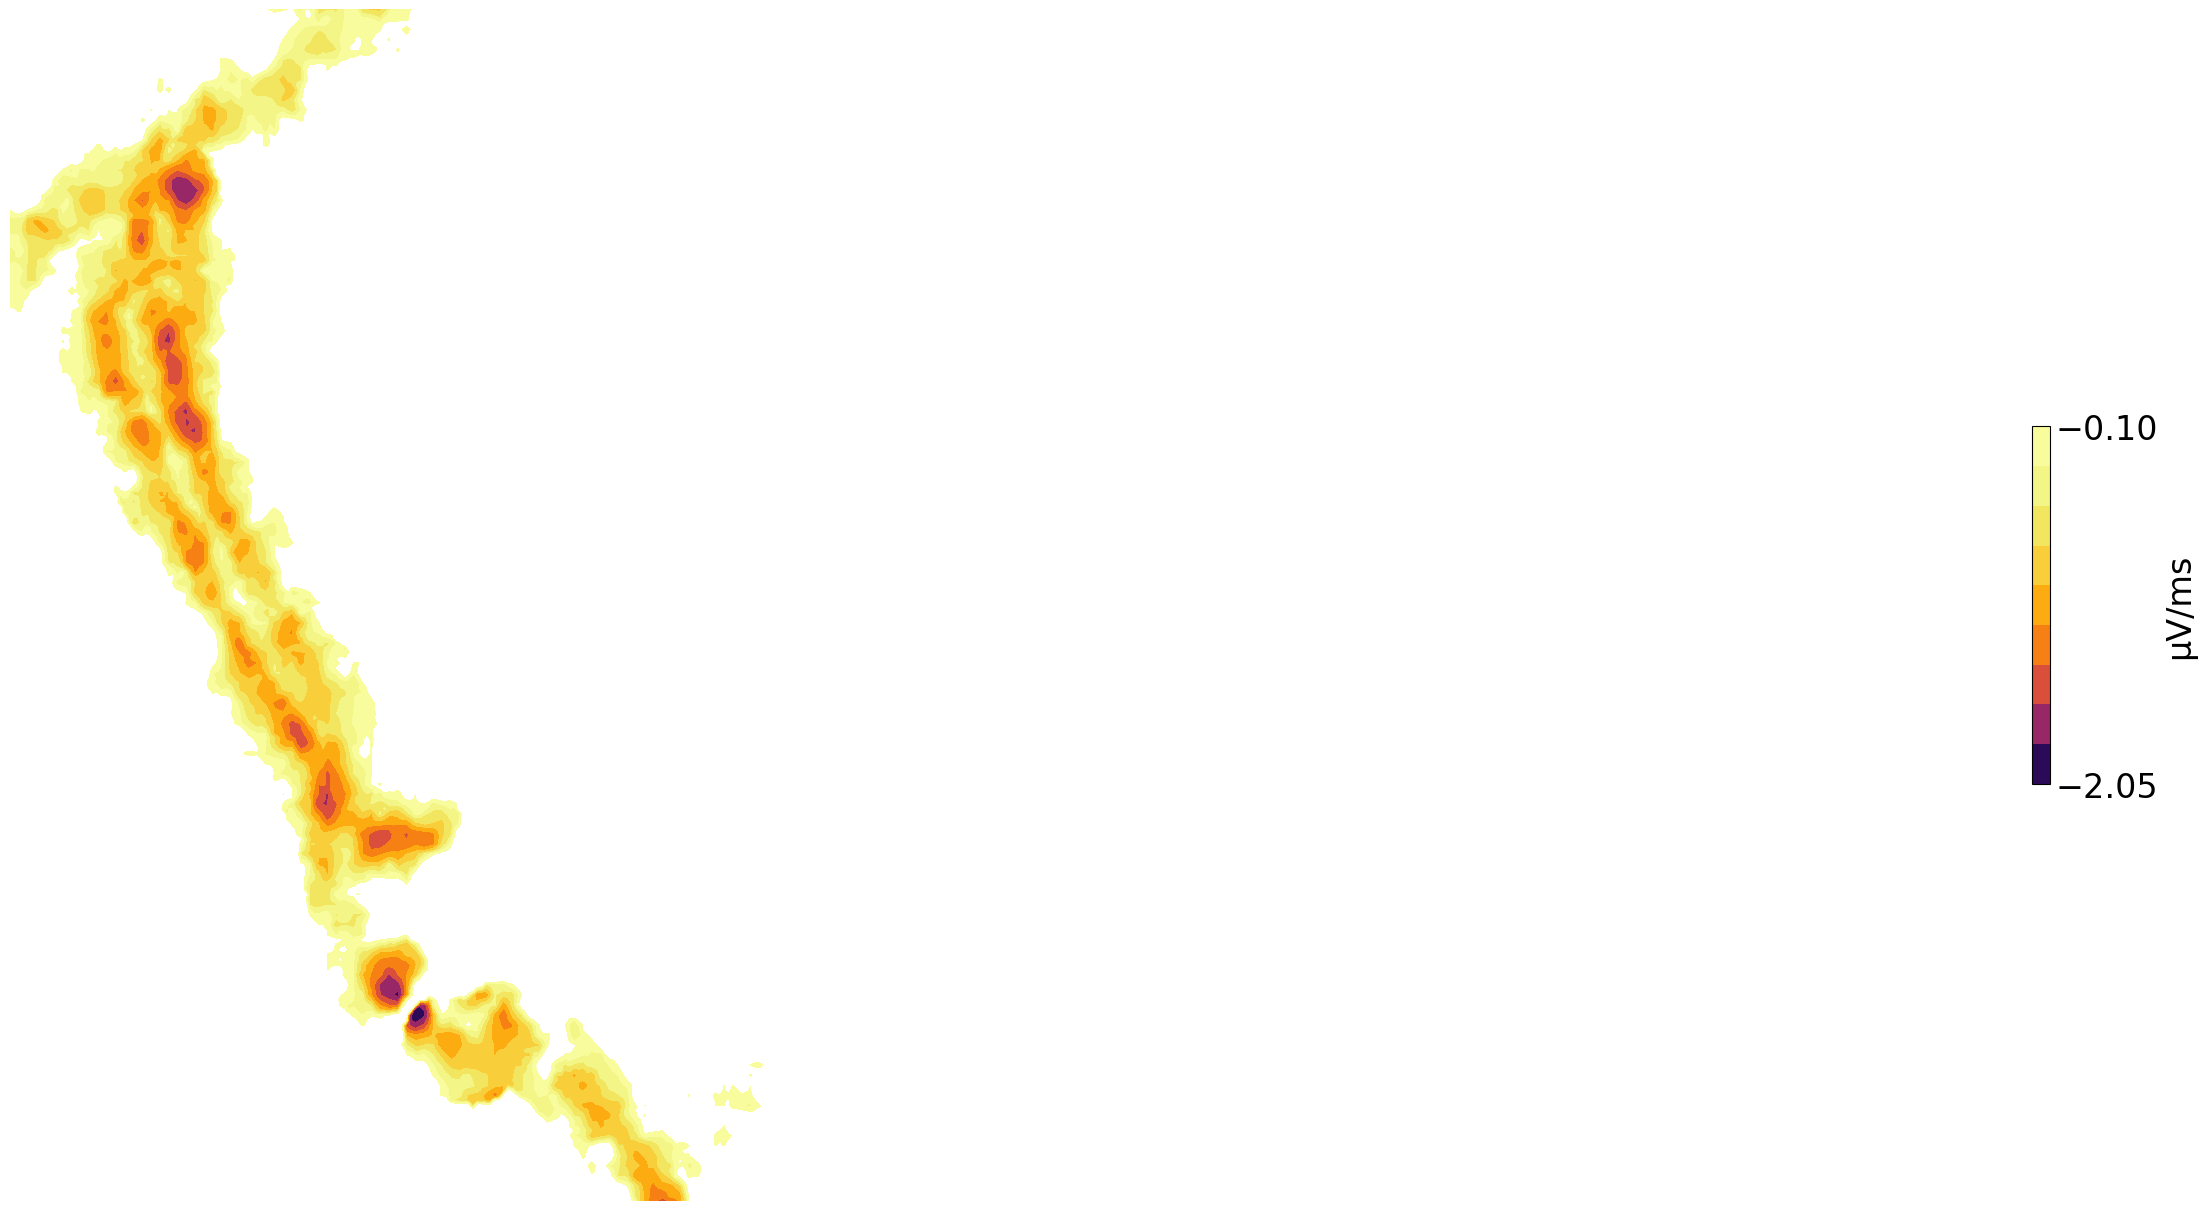

In [91]:
vis.plot_filled_contour(interp_temp,qc_skeleton,params,radius=10,save_path=[])

In [ ]:
import pickle
# Save the skeleton 
# Ideally, the skeleton should be saved in the same folder as the templates
with open('skel.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(qc_skeleton, file) 

In [ ]:
# Load the skeleton
with open('skel.pkl', 'rb') as file: 
    # Call load method to deserialze 
    myvar = pickle.load(file) 